# 🚀 XGBoost para Predicción de Fertilizantes Óptimos

## 🎯 Objetivo
En este notebook, abordaremos el desafío **Predicting Optimal Fertilizers** (Tabular Playground Series S5E6) de Kaggle utilizando **exclusivamente XGBoost**.

El objetivo es **predecir el fertilizante más adecuado** (`Fertilizer Name`) basado en condiciones ambientales, de suelo y tipo de cultivo. Este es un problema de **clasificación multiclase** y nuestra métrica de evaluación será **MAP@3** (Mean Average Precision at 3).

## 📊 Descripción del Dataset
La competencia proporciona dos archivos CSV principales:
- **`train.csv`**: Contiene 750,000 muestras de entrenamiento con 8 características y la variable objetivo
- **`test.csv`**: Contiene 250,000 muestras de prueba para hacer predicciones

### Características:
- `Temparature` (float): Temperatura ambiente (°C)
- `Humidity` (float): Humedad relativa (%)
- `Moisture` (float): Humedad del suelo (%)
- `Soil Type` (categórica): Tipo de suelo (Red, Black, Sandy, Clayey, Loamy)
- `Crop Type` (categórica): Tipo de cultivo (Wheat, Rice, Cotton, etc.)
- `Nitrogen` (int): Contenido de nitrógeno en el suelo
- `Potassium` (int): Contenido de potasio en el suelo
- `Phosphorous` (int): Contenido de fósforo en el suelo
- `Fertilizer Name` (objetivo): El fertilizante a predecir (7 clases)

---

# 📚 1. Importar Librerías

### Importación de librerías necesarias para análisis de datos, visualización y modelado

In [1]:
# ===== Suprimir Advertencias =====
import warnings
warnings.filterwarnings("ignore")

# ===== Librerías Principales =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time

# ===== Preprocesamiento =====
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ===== XGBoost =====
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping

# ===== Configuración de Visualización =====
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
np.random.seed(42)

print("✅ Librerías importadas exitosamente")
print(f"📦 XGBoost version: {xgb.__version__}")

✅ Librerías importadas exitosamente
📦 XGBoost version: 3.0.2


# 📁 2. Cargar Datos

### Carga de archivos CSV desde la carpeta de datos

In [2]:
# Cargar datos desde la carpeta local
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

print("📊 Datos cargados exitosamente:")
print(f"  • Train shape: {train.shape}")
print(f"  • Test shape: {test.shape}")
print(f"  • Total samples: {len(train) + len(test):,}")

# Mostrar primeras filas
print("\n🔍 Primeras 3 filas del conjunto de entrenamiento:")
display(train.head(3))

📊 Datos cargados exitosamente:
  • Train shape: (750000, 10)
  • Test shape: (250000, 9)
  • Total samples: 1,000,000

🔍 Primeras 3 filas del conjunto de entrenamiento:


,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17


# 🔍 3. Inspección Inicial de los Datos

### Análisis básico de la estructura y características de los datos

In [3]:
# Información general del dataset
print("📋 INFORMACIÓN GENERAL DEL DATASET")
print("=" * 50)
train.info()

print("\n📊 ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 50)
display(train.describe())

print("\n🔍 VALORES ÚNICOS POR COLUMNA")
print("=" * 50)
for col in train.columns:
    unique_count = train[col].nunique()
    print(f"{col:15}: {unique_count:3} valores únicos")
    if unique_count < 10 and col != 'id':
        print(f"                -> {list(train[col].unique())}")

print("\n❌ VALORES NULOS")
print("=" * 50)
null_counts = train.isnull().sum()
if null_counts.sum() == 0:
    print("✅ No hay valores nulos en el dataset")
else:
    print(null_counts[null_counts > 0])

📋 INFORMACIÓN GENERAL DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               750000 non-null  int64 
 1   Temparature      750000 non-null  int64 
 2   Humidity         750000 non-null  int64 
 3   Moisture         750000 non-null  int64 
 4   Soil Type        750000 non-null  object
 5   Crop Type        750000 non-null  object
 6   Nitrogen         750000 non-null  int64 
 7   Potassium        750000 non-null  int64 
 8   Phosphorous      750000 non-null  int64 
 9   Fertilizer Name  750000 non-null  object
dtypes: int64(7), object(3)
memory usage: 57.2+ MB

📊 ESTADÍSTICAS DESCRIPTIVAS


,id,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,216506.495284,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,0.000000,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,187499.750000,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,374999.500000,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,562499.250000,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,749999.000000,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000



🔍 VALORES ÚNICOS POR COLUMNA
id             : 750000 valores únicos
Temparature    :  14 valores únicos
Humidity       :  23 valores únicos
Moisture       :  41 valores únicos
Soil Type      :   5 valores únicos
                -> ['Clayey', 'Sandy', 'Red', 'Loamy', 'Black']
Crop Type      :  11 valores únicos
Nitrogen       :  39 valores únicos
Potassium      :  20 valores únicos
Phosphorous    :  43 valores únicos
Fertilizer Name:   7 valores únicos
                -> ['28-28', '17-17-17', '10-26-26', 'DAP', '20-20', '14-35-14', 'Urea']

❌ VALORES NULOS
✅ No hay valores nulos en el dataset


# 📈 4. Análisis Exploratorio de Datos (EDA)

### Visualización y análisis detallado de las características

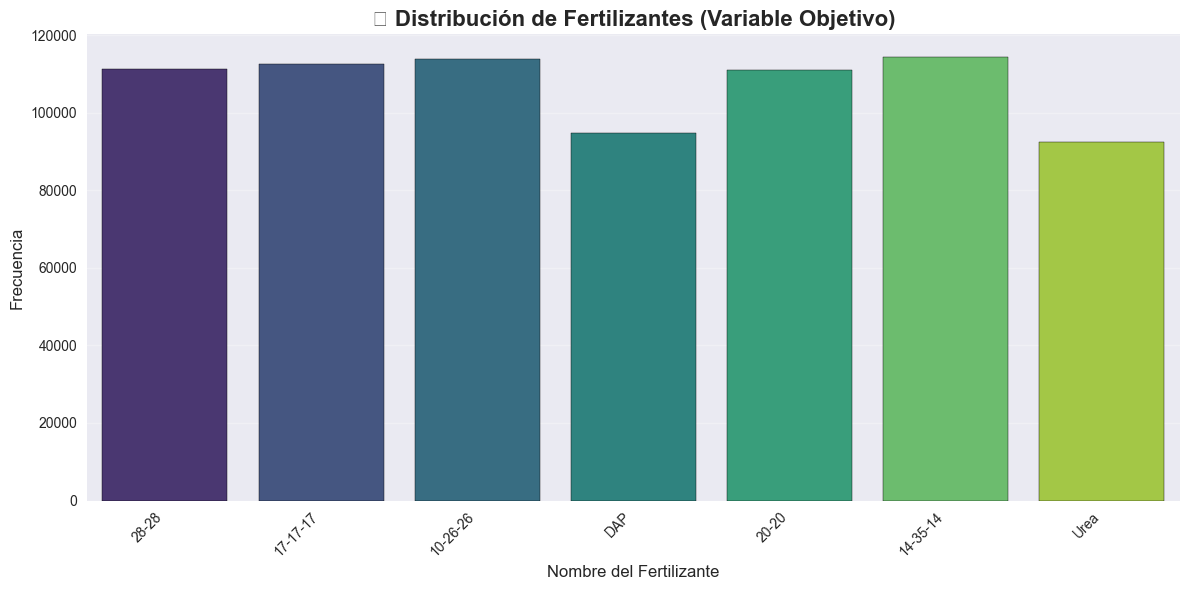

📊 DISTRIBUCIÓN DE FERTILIZANTES:
  14-35-14       : 114,436 ( 15.3%)
  10-26-26       : 113,887 ( 15.2%)
  17-17-17       : 112,453 ( 15.0%)
  28-28          : 111,158 ( 14.8%)
  20-20          : 110,889 ( 14.8%)
  DAP            : 94,860 ( 12.6%)
  Urea           : 92,317 ( 12.3%)

🎯 Total de clases: 7
📊 Distribución balanceada: Sí (std: 1.3%)


In [4]:
# ===== Distribución de la Variable Objetivo =====
plt.figure(figsize=(12, 6))
sns.countplot(data=train, x='Fertilizer Name', palette='viridis', edgecolor='black')
plt.title('🎯 Distribución de Fertilizantes (Variable Objetivo)', fontsize=16, fontweight='bold')
plt.xlabel('Nombre del Fertilizante', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Estadísticas de la variable objetivo
print("📊 DISTRIBUCIÓN DE FERTILIZANTES:")
fert_counts = train['Fertilizer Name'].value_counts()
fert_props = train['Fertilizer Name'].value_counts(normalize=True) * 100

for fertilizer in fert_counts.index:
    count = fert_counts[fertilizer]
    prop = fert_props[fertilizer]
    print(f"  {fertilizer:15}: {count:6,} ({prop:5.1f}%)")

print(f"\n🎯 Total de clases: {train['Fertilizer Name'].nunique()}")
print(f"📊 Distribución balanceada: {'Sí' if fert_props.std() < 5 else 'No'} (std: {fert_props.std():.1f}%)")

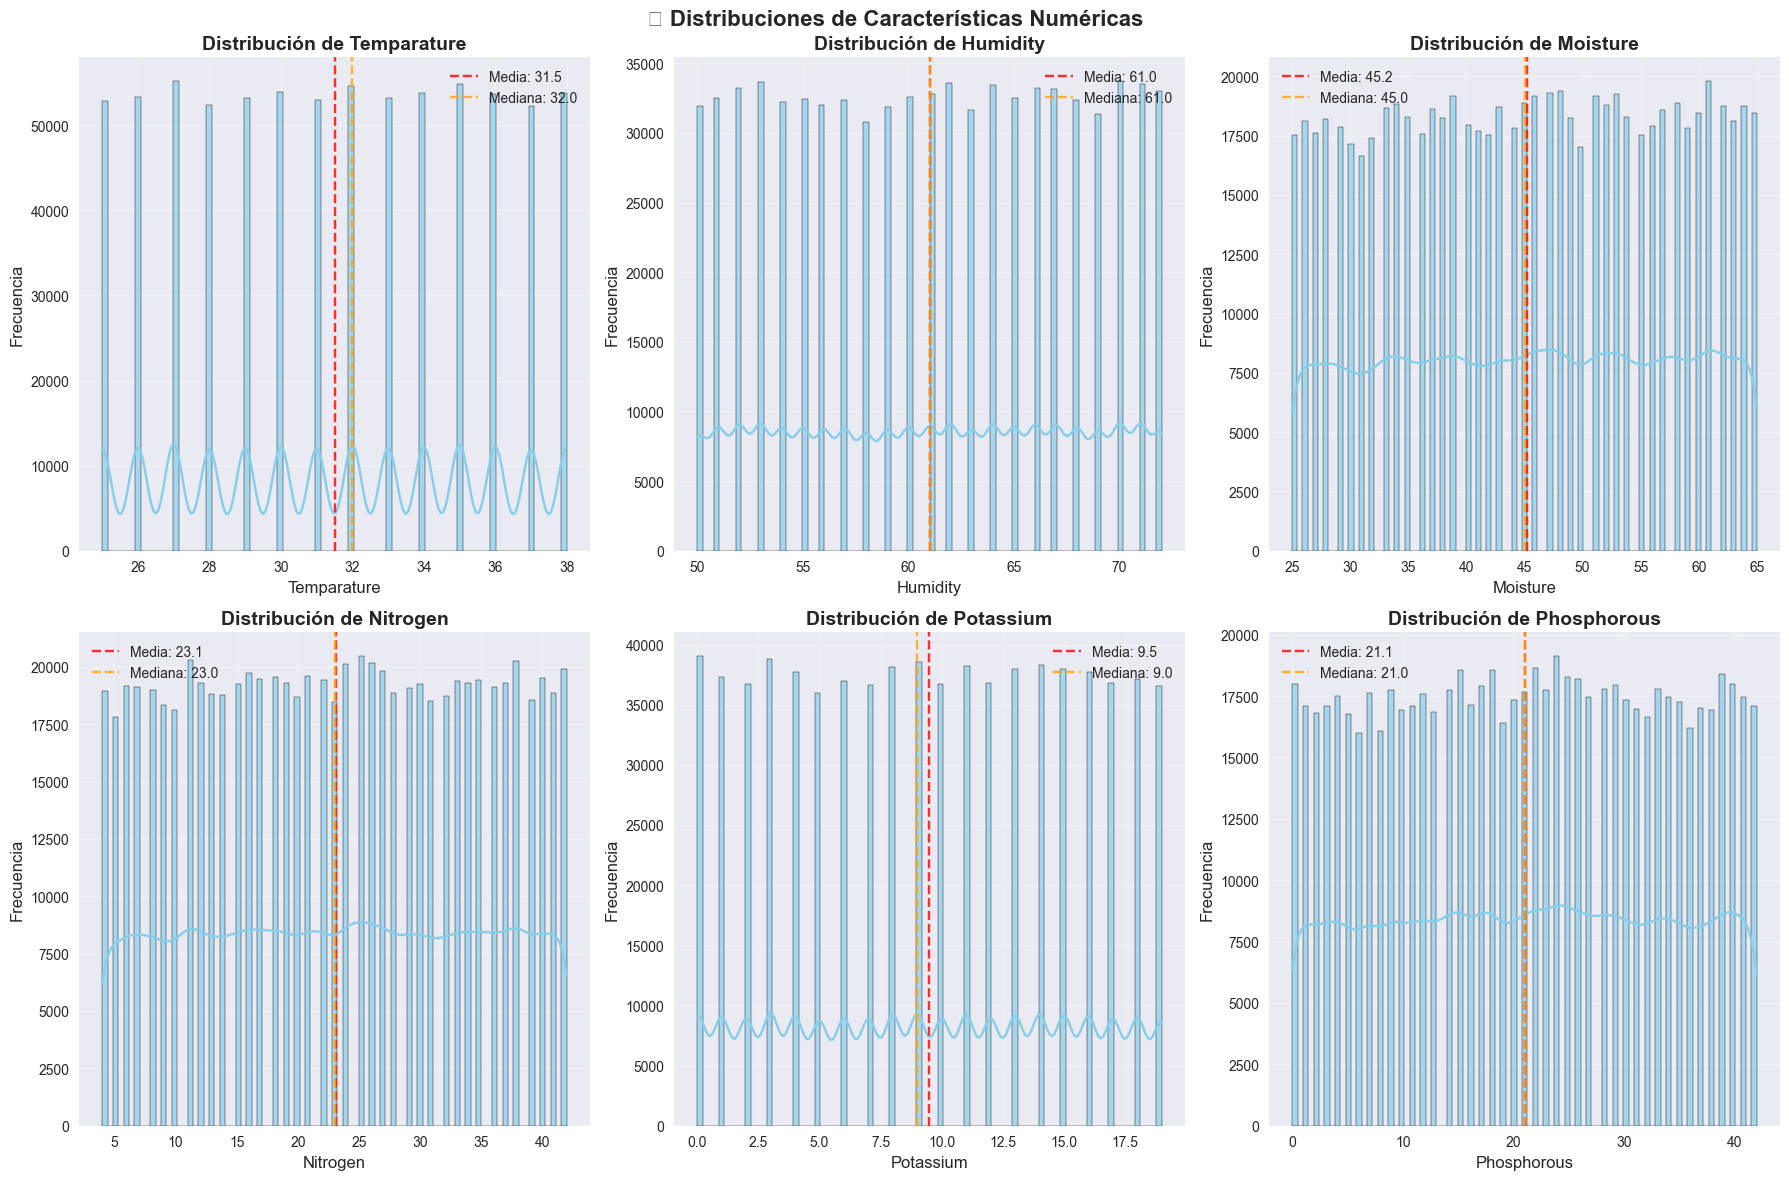


📊 ESTADÍSTICAS DETALLADAS DE CARACTERÍSTICAS NUMÉRICAS:

Temparature:
  Rango: 25.0 - 38.0
  Media ± Std: 31.5 ± 4.0
  Q1, Q2, Q3: 28.0, 32.0, 35.0

Humidity:
  Rango: 50.0 - 72.0
  Media ± Std: 61.0 ± 6.6
  Q1, Q2, Q3: 55.0, 61.0, 67.0

Moisture:
  Rango: 25.0 - 65.0
  Media ± Std: 45.2 ± 11.8
  Q1, Q2, Q3: 35.0, 45.0, 55.0

Nitrogen:
  Rango: 4.0 - 42.0
  Media ± Std: 23.1 ± 11.2
  Q1, Q2, Q3: 13.0, 23.0, 33.0

Potassium:
  Rango: 0.0 - 19.0
  Media ± Std: 9.5 ± 5.8
  Q1, Q2, Q3: 4.0, 9.0, 14.0

Phosphorous:
  Rango: 0.0 - 42.0
  Media ± Std: 21.1 ± 12.3
  Q1, Q2, Q3: 10.0, 21.0, 32.0


In [5]:
# ===== Distribución de Características Numéricas =====
num_cols = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    # Histograma con KDE
    sns.histplot(train[col], kde=True, ax=axes[i], color='skyblue', alpha=0.7)
    axes[i].set_title(f'Distribución de {col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frecuencia', fontsize=12)
    axes[i].grid(alpha=0.3)
    
    # Agregar estadísticas en el gráfico
    mean_val = train[col].mean()
    median_val = train[col].median()
    axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Media: {mean_val:.1f}')
    axes[i].axvline(median_val, color='orange', linestyle='--', alpha=0.8, label=f'Mediana: {median_val:.1f}')
    axes[i].legend()

plt.suptitle('📊 Distribuciones de Características Numéricas', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Estadísticas detalladas
print("\n📊 ESTADÍSTICAS DETALLADAS DE CARACTERÍSTICAS NUMÉRICAS:")
print("=" * 80)
for col in num_cols:
    stats = train[col].describe()
    print(f"\n{col}:")
    print(f"  Rango: {stats['min']:.1f} - {stats['max']:.1f}")
    print(f"  Media ± Std: {stats['mean']:.1f} ± {stats['std']:.1f}")
    print(f"  Q1, Q2, Q3: {stats['25%']:.1f}, {stats['50%']:.1f}, {stats['75%']:.1f}")

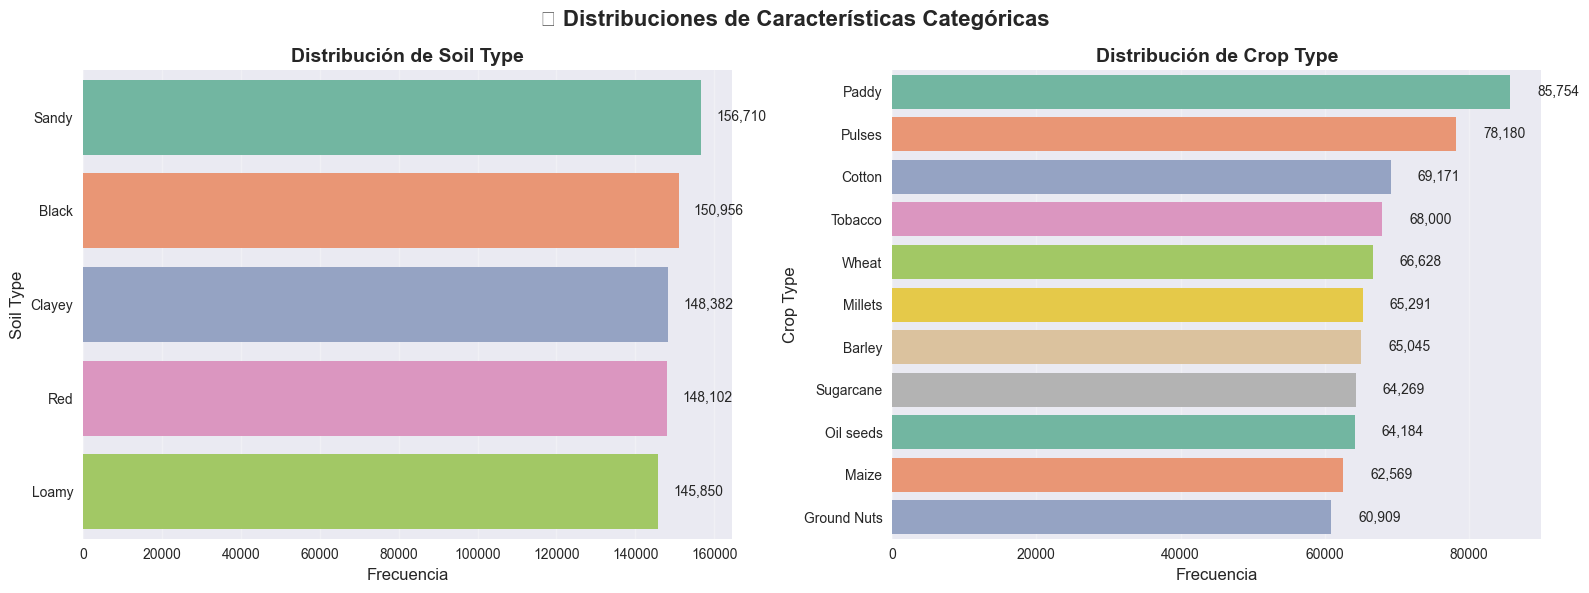


📊 ESTADÍSTICAS DE CARACTERÍSTICAS CATEGÓRICAS:

Soil Type:
  Sandy          : 156,710 ( 20.9%)
  Black          : 150,956 ( 20.1%)
  Clayey         : 148,382 ( 19.8%)
  Red            : 148,102 ( 19.7%)
  Loamy          : 145,850 ( 19.4%)
  Total categorías: 5

Crop Type:
  Paddy          : 85,754 ( 11.4%)
  Pulses         : 78,180 ( 10.4%)
  Cotton         : 69,171 (  9.2%)
  Tobacco        : 68,000 (  9.1%)
  Wheat          : 66,628 (  8.9%)
  Millets        : 65,291 (  8.7%)
  Barley         : 65,045 (  8.7%)
  Sugarcane      : 64,269 (  8.6%)
  Oil seeds      : 64,184 (  8.6%)
  Maize          : 62,569 (  8.3%)
  Ground Nuts    : 60,909 (  8.1%)
  Total categorías: 11


In [6]:
# ===== Distribución de Características Categóricas =====
cat_cols = ['Soil Type', 'Crop Type']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, col in enumerate(cat_cols):
    # Gráfico de barras
    value_counts = train[col].value_counts()
    sns.barplot(x=value_counts.values, y=value_counts.index, ax=axes[i], palette='Set2')
    axes[i].set_title(f'Distribución de {col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Frecuencia', fontsize=12)
    axes[i].set_ylabel(col, fontsize=12)
    axes[i].grid(axis='x', alpha=0.3)
    
    # Agregar valores en las barras
    for j, v in enumerate(value_counts.values):
        axes[i].text(v + len(train) * 0.005, j, f'{v:,}', va='center', fontsize=10)

plt.suptitle('📊 Distribuciones de Características Categóricas', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Estadísticas categóricas
print("\n📊 ESTADÍSTICAS DE CARACTERÍSTICAS CATEGÓRICAS:")
print("=" * 70)
for col in cat_cols:
    print(f"\n{col}:")
    value_counts = train[col].value_counts()
    value_props = train[col].value_counts(normalize=True) * 100
    
    for category in value_counts.index:
        count = value_counts[category]
        prop = value_props[category]
        print(f"  {category:15}: {count:6,} ({prop:5.1f}%)")
    
    print(f"  Total categorías: {train[col].nunique()}")

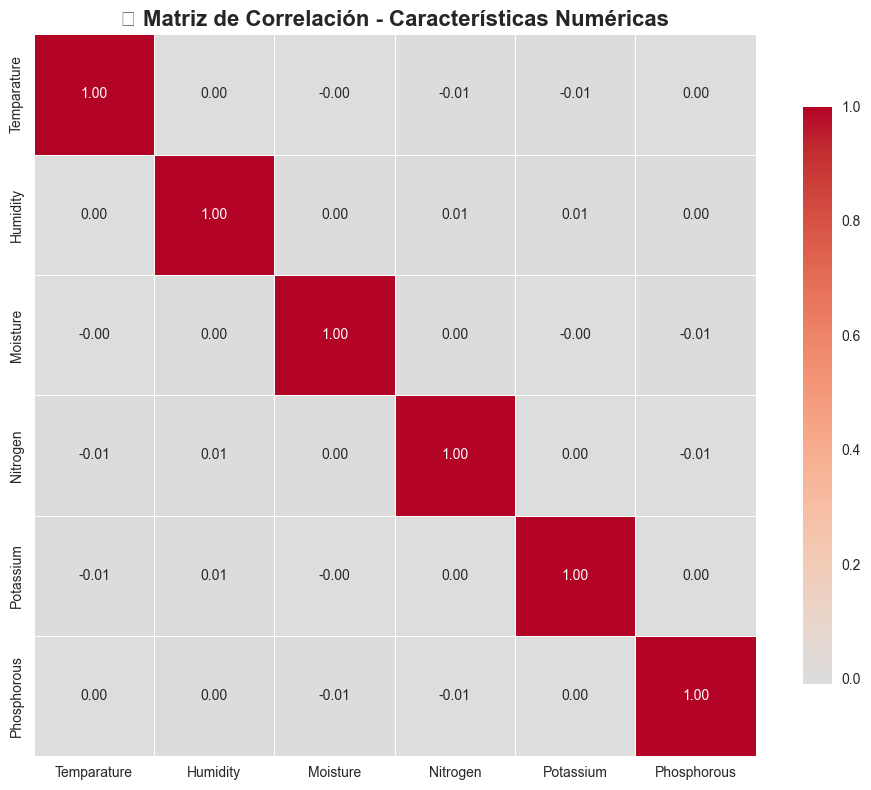


🔗 CORRELACIONES SIGNIFICATIVAS (|r| > 0.3):
  ✅ No hay correlaciones altas entre variables numéricas

🧪 ANÁLISIS DE CARACTERÍSTICAS POR FERTILIZANTE:


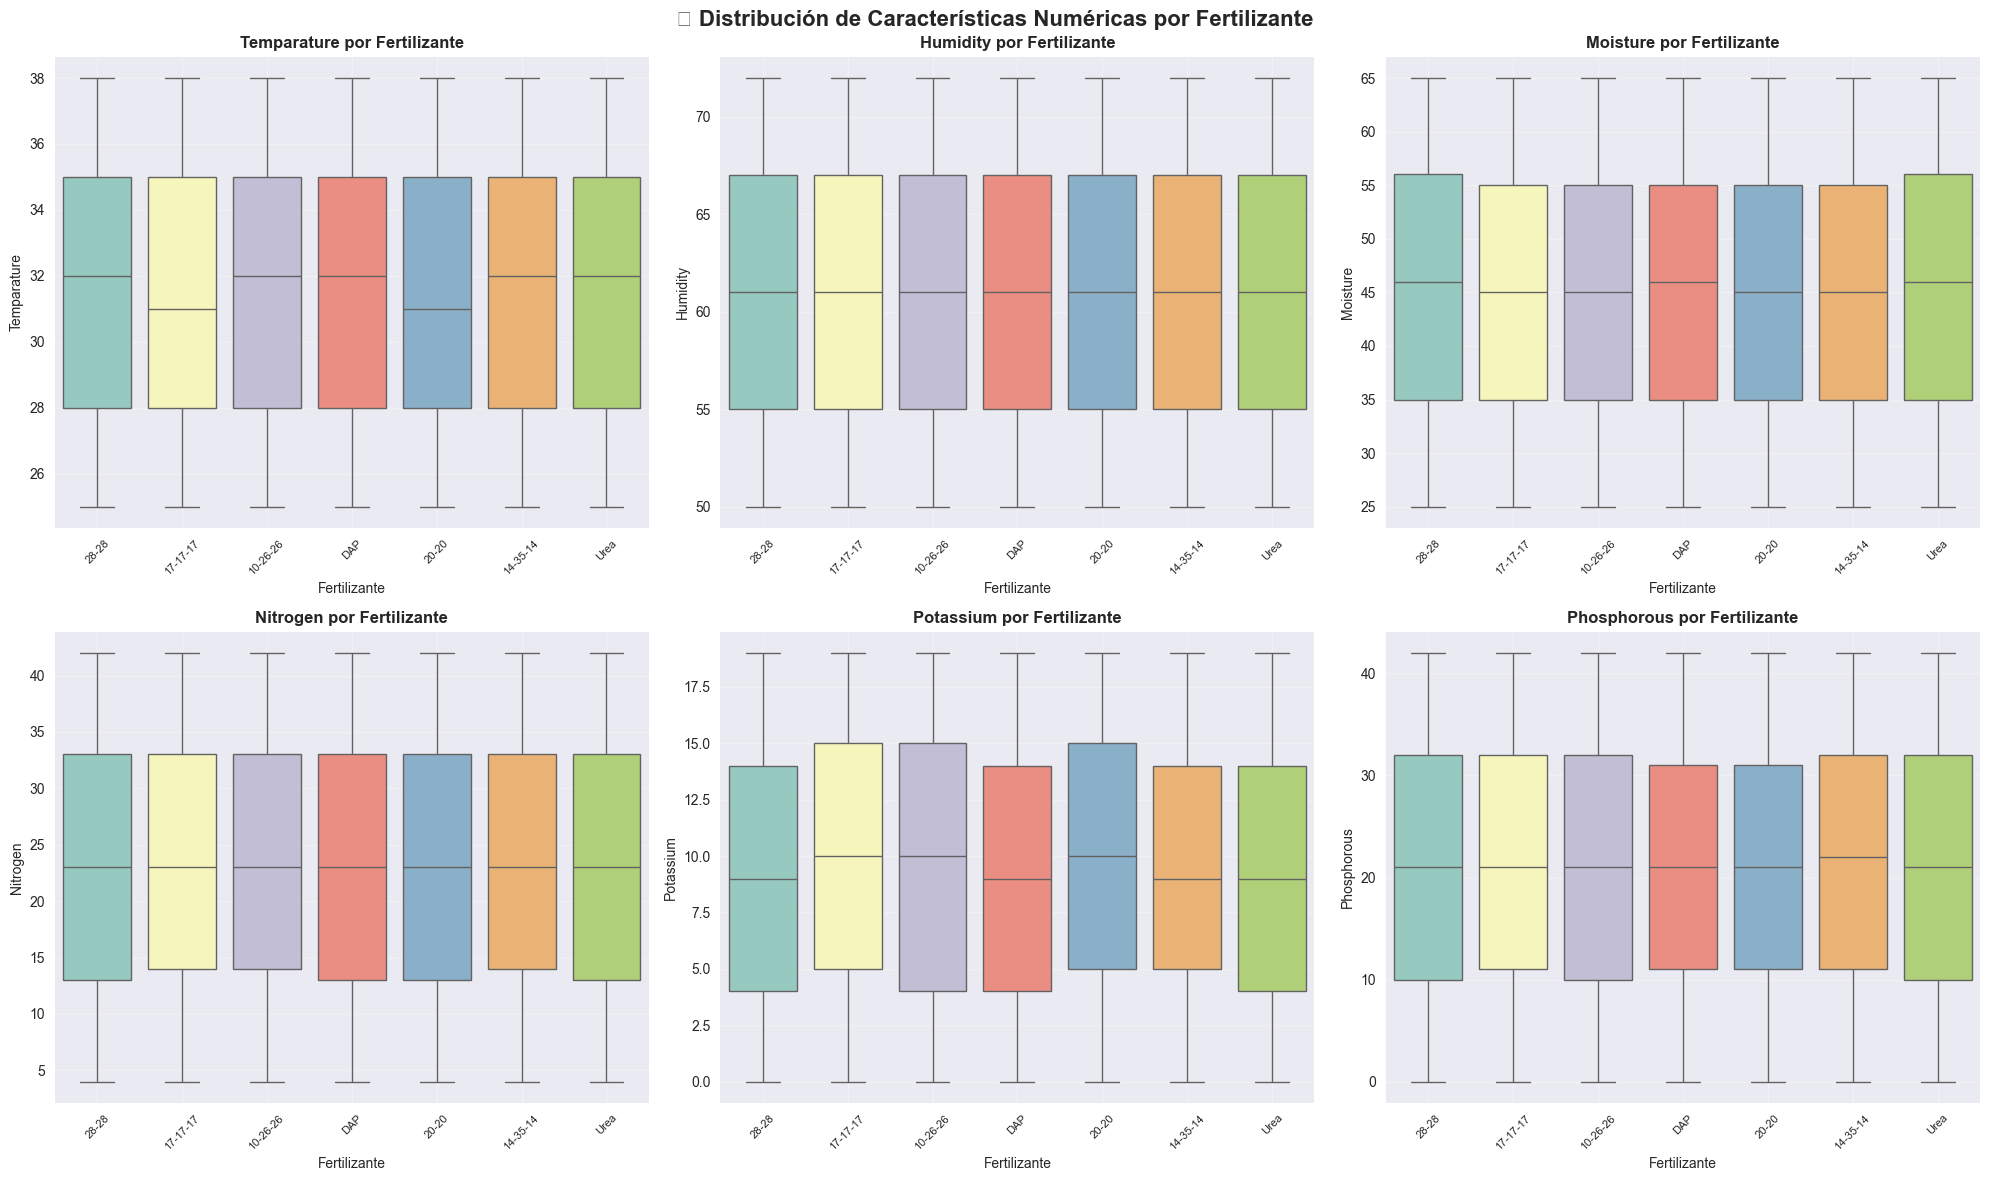

In [7]:
# ===== Matriz de Correlación =====
plt.figure(figsize=(10, 8))
corr_matrix = train[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('🔗 Matriz de Correlación - Características Numéricas', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Identificar correlaciones altas
print("\n🔗 CORRELACIONES SIGNIFICATIVAS (|r| > 0.3):")
print("=" * 60)
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.3:
            var1 = corr_matrix.columns[i]
            var2 = corr_matrix.columns[j]
            corr_pairs.append((var1, var2, corr_val))
            print(f"  {var1} ↔ {var2}: {corr_val:.3f}")

if not corr_pairs:
    print("  ✅ No hay correlaciones altas entre variables numéricas")

# ===== Análisis por Fertilizante =====
print("\n🧪 ANÁLISIS DE CARACTERÍSTICAS POR FERTILIZANTE:")
print("=" * 70)

# Boxplot de características numéricas por fertilizante
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    sns.boxplot(data=train, x='Fertilizer Name', y=col, ax=axes[i], palette='Set3')
    axes[i].set_title(f'{col} por Fertilizante', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Fertilizante', fontsize=10)
    axes[i].set_ylabel(col, fontsize=10)
    axes[i].tick_params(axis='x', rotation=45, labelsize=8)
    axes[i].grid(alpha=0.3)

plt.suptitle('📊 Distribución de Características Numéricas por Fertilizante', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ⚙️ 5. Preprocesamiento de Datos

### Preparación de datos para el modelado con XGBoost

In [8]:
# ===== Preparación de Datos =====
print("🔧 INICIANDO PREPROCESAMIENTO DE DATOS")
print("=" * 50)

# Crear copia de trabajo
train_processed = train.copy()
test_processed = test.copy()

# Identificar columnas
num_cols = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']
cat_cols = ['Soil Type', 'Crop Type']
target_col = 'Fertilizer Name'

print(f"📊 Características numéricas: {len(num_cols)}")
print(f"📊 Características categóricas: {len(cat_cols)}")
print(f"🎯 Variable objetivo: {target_col}")

# ===== Codificación de Variables Categóricas =====
print("\n🏷️ CODIFICANDO VARIABLES CATEGÓRICAS...")

# Label encoding para características categóricas
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    # Combinar valores únicos de train y test para encoding consistente
    all_values = pd.concat([train_processed[col], test_processed[col]]).unique()
    le.fit(all_values)
    
    train_processed[col + '_encoded'] = le.transform(train_processed[col])
    test_processed[col + '_encoded'] = le.transform(test_processed[col])
    label_encoders[col] = le
    
    print(f"  ✅ {col}: {len(all_values)} categorías -> valores 0-{len(all_values)-1}")

# ===== Codificación de Variable Objetivo =====
print("\n🎯 CODIFICANDO VARIABLE OBJETIVO...")
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(train_processed[target_col])
train_processed[target_col + '_encoded'] = y_encoded

print(f"  ✅ {target_col}: {len(target_encoder.classes_)} clases")
for i, class_name in enumerate(target_encoder.classes_):
    print(f"     {i}: {class_name}")

# ===== Preparar Features Finales =====
feature_cols = num_cols + [col + '_encoded' for col in cat_cols]
print(f"\n📋 CARACTERÍSTICAS FINALES: {len(feature_cols)}")
for i, col in enumerate(feature_cols):
    print(f"  {i+1:2}. {col}")

# Separar características y objetivo
X = train_processed[feature_cols]
y = train_processed[target_col + '_encoded']
X_test = test_processed[feature_cols]

print(f"\n✅ PREPROCESAMIENTO COMPLETADO")
print(f"  📊 X shape: {X.shape}")
print(f"  🎯 y shape: {y.shape}")
print(f"  📊 X_test shape: {X_test.shape}")

🔧 INICIANDO PREPROCESAMIENTO DE DATOS
📊 Características numéricas: 6
📊 Características categóricas: 2
🎯 Variable objetivo: Fertilizer Name

🏷️ CODIFICANDO VARIABLES CATEGÓRICAS...
  ✅ Soil Type: 5 categorías -> valores 0-4
  ✅ Crop Type: 11 categorías -> valores 0-10

🎯 CODIFICANDO VARIABLE OBJETIVO...
  ✅ Fertilizer Name: 7 clases
     0: 10-26-26
     1: 14-35-14
     2: 17-17-17
     3: 20-20
     4: 28-28
     5: DAP
     6: Urea

📋 CARACTERÍSTICAS FINALES: 8
   1. Temparature
   2. Humidity
   3. Moisture
   4. Nitrogen
   5. Potassium
   6. Phosphorous
   7. Soil Type_encoded
   8. Crop Type_encoded

✅ PREPROCESAMIENTO COMPLETADO
  📊 X shape: (750000, 8)
  🎯 y shape: (750000,)
  📊 X_test shape: (250000, 8)


In [9]:
# ===== Verificación de Preprocesamiento =====
print("🔍 VERIFICACIÓN DE DATOS PREPROCESADOS")
print("=" * 50)

# Verificar que no hay valores nulos
print("❌ Valores nulos en X:")
null_check = X.isnull().sum()
if null_check.sum() == 0:
    print("  ✅ No hay valores nulos")
else:
    print(null_check[null_check > 0])

print("\n❌ Valores nulos en X_test:")
null_check_test = X_test.isnull().sum()
if null_check_test.sum() == 0:
    print("  ✅ No hay valores nulos")
else:
    print(null_check_test[null_check_test > 0])

# Verificar rangos de datos
print("\n📊 RANGOS DE CARACTERÍSTICAS:")
for col in feature_cols:
    min_val = X[col].min()
    max_val = X[col].max()
    print(f"  {col:20}: [{min_val:6.1f}, {max_val:6.1f}]")

# Verificar distribución de clases
print("\n🎯 DISTRIBUCIÓN DE CLASES CODIFICADAS:")
class_counts = pd.Series(y).value_counts().sort_index()
for class_idx, count in class_counts.items():
    class_name = target_encoder.classes_[class_idx]
    percentage = (count / len(y)) * 100
    print(f"  {class_idx}: {class_name:15} -> {count:6,} ({percentage:5.1f}%)")

# Mostrar muestra de datos finales
print("\n📋 MUESTRA DE DATOS FINALES:")
print("\nX (primeras 3 filas):")
display(X.head(3))
print("\ny (primeros 10 valores):")
print(y.head(10).values)

🔍 VERIFICACIÓN DE DATOS PREPROCESADOS
❌ Valores nulos en X:
  ✅ No hay valores nulos

❌ Valores nulos en X_test:
  ✅ No hay valores nulos

📊 RANGOS DE CARACTERÍSTICAS:
  Temparature         : [  25.0,   38.0]
  Humidity            : [  50.0,   72.0]
  Moisture            : [  25.0,   65.0]
  Nitrogen            : [   4.0,   42.0]
  Potassium           : [   0.0,   19.0]
  Phosphorous         : [   0.0,   42.0]
  Soil Type_encoded   : [   0.0,    4.0]
  Crop Type_encoded   : [   0.0,   10.0]

🎯 DISTRIBUCIÓN DE CLASES CODIFICADAS:
  0: 10-26-26        -> 113,887 ( 15.2%)
  1: 14-35-14        -> 114,436 ( 15.3%)
  2: 17-17-17        -> 112,453 ( 15.0%)
  3: 20-20           -> 110,889 ( 14.8%)
  4: 28-28           -> 111,158 ( 14.8%)
  5: DAP             -> 94,860 ( 12.6%)
  6: Urea            -> 92,317 ( 12.3%)

📋 MUESTRA DE DATOS FINALES:

X (primeras 3 filas):


,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous,Soil Type_encoded,Crop Type_encoded
0,37,70,36,36,4,5,1,8
1,27,69,65,30,6,18,4,4
2,29,63,32,24,12,16,4,4



y (primeros 10 valores):
[4 4 2 0 5 3 4 1 2 3]


# 🔄 6. División de Datos para Entrenamiento y Validación

### Configuración de validación cruzada estratificada para evaluación robusta

In [10]:
# ===== Configuración de Validación Cruzada =====
print("🔄 CONFIGURANDO VALIDACIÓN CRUZADA")
print("=" * 50)

# Parámetros de CV
N_SPLITS = 10  # Número de folds
RANDOM_STATE = 42
SHUFFLE = True

# Inicializar StratifiedKFold
skf = StratifiedKFold(
    n_splits=N_SPLITS, 
    shuffle=SHUFFLE, 
    random_state=RANDOM_STATE
)

print(f"📊 Configuración de Validación Cruzada:")
print(f"  • Número de folds: {N_SPLITS}")
print(f"  • Estratificada: Sí (mantiene proporción de clases)")
print(f"  • Shuffle: {SHUFFLE}")
print(f"  • Random state: {RANDOM_STATE}")

# Verificar distribución por fold
print(f"\n🔍 VERIFICACIÓN DE DISTRIBUCIÓN POR FOLD:")
fold_info = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]
    
    train_size = len(train_idx)
    val_size = len(val_idx)
    train_prop = train_size / len(y)
    val_prop = val_size / len(y)
    
    fold_info.append({
        'fold': fold,
        'train_size': train_size,
        'val_size': val_size,
        'train_prop': train_prop,
        'val_prop': val_prop
    })
    
    if fold <= 3:  # Mostrar solo los primeros 3 folds
        print(f"  Fold {fold}: Train={train_size:6,} ({train_prop:.1%}) | Val={val_size:6,} ({val_prop:.1%})")

print(f"  ... (mostrando solo primeros 3 de {N_SPLITS} folds)")

# Estadísticas promedio
avg_train_size = np.mean([info['train_size'] for info in fold_info])
avg_val_size = np.mean([info['val_size'] for info in fold_info])

print(f"\n📊 ESTADÍSTICAS PROMEDIO:")
print(f"  • Tamaño promedio de entrenamiento: {avg_train_size:,.0f}")
print(f"  • Tamaño promedio de validación: {avg_val_size:,.0f}")
print(f"  • Proporción train/val: {avg_train_size/avg_val_size:.1f}:1")

# ===== Función MAP@3 =====
print(f"\n📊 DEFINIENDO MÉTRICA MAP@3")
print("=" * 30)

def mapk(actual, predicted, k=3):
    """
    Compute mean average precision at k (MAP@k).
    
    Parameters:
    actual : array-like, actual class labels
    predicted : array-like, predicted class indices (top k for each sample)
    k : int, number of predictions to consider
    
    Returns:
    float : MAP@k score
    """
    def apk(a, p, k):
        score = 0.0
        for i in range(min(k, len(p))):
            if p[i] == a:
                score += 1.0 / (i + 1)
                break  # Solo la primera predicción correcta cuenta
        return score
    
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

print("✅ Función MAP@3 definida")
print("  • Evalúa si la clase correcta está en las top-3 predicciones")
print("  • Pondera por posición: 1°=1.0, 2°=0.5, 3°=0.33")
print("  • Rango: 0.0 (peor) a 1.0 (mejor)")

🔄 CONFIGURANDO VALIDACIÓN CRUZADA
📊 Configuración de Validación Cruzada:
  • Número de folds: 10
  • Estratificada: Sí (mantiene proporción de clases)
  • Shuffle: True
  • Random state: 42

🔍 VERIFICACIÓN DE DISTRIBUCIÓN POR FOLD:
  Fold 1: Train=675,000 (90.0%) | Val=75,000 (10.0%)
  Fold 2: Train=675,000 (90.0%) | Val=75,000 (10.0%)
  Fold 3: Train=675,000 (90.0%) | Val=75,000 (10.0%)
  ... (mostrando solo primeros 3 de 10 folds)

📊 ESTADÍSTICAS PROMEDIO:
  • Tamaño promedio de entrenamiento: 675,000
  • Tamaño promedio de validación: 75,000
  • Proporción train/val: 9.0:1

📊 DEFINIENDO MÉTRICA MAP@3
✅ Función MAP@3 definida
  • Evalúa si la clase correcta está en las top-3 predicciones
  • Pondera por posición: 1°=1.0, 2°=0.5, 3°=0.33
  • Rango: 0.0 (peor) a 1.0 (mejor)


# 🚀 7. Entrenamiento del Modelo con XGBoost

### Configuración optimizada de XGBoost con validación cruzada robusta

In [11]:
# ===== Configuración de Hiperparámetros XGBoost =====
print("⚙️ CONFIGURANDO HIPERPARÁMETROS XGBOOST")
print("=" * 50)

# Configuración optimizada basada en el análisis del notebook de referencia
xgb_params = {
    # Parámetros principales
    'objective': 'multi:softprob',
    'num_class': len(target_encoder.classes_),
    'eval_metric': 'mlogloss',
    
    # Estructura del árbol
    'max_depth': 12,
    'n_estimators': 3000,  # Alto número con early stopping
    'learning_rate': 0.03,
    
    # Regularización
    'reg_alpha': 2.7,      # L1 regularization
    'reg_lambda': 1.4,     # L2 regularization
    'gamma': 0.26,         # Minimum split loss
    'max_delta_step': 4,   # Para clases desbalanceadas
    
    # Muestreo
    'subsample': 0.86,
    'colsample_bytree': 0.467,
    'colsample_bylevel': 0.8,
    'colsample_bynode': 0.8,
    
    # Optimización
    'tree_method': 'hist',
    'enable_categorical': True,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbosity': 0
}

# Añadir configuración de GPU si está disponible
try:
    import GPUtil
    gpus = GPUtil.getGPUs()
    if gpus:
        xgb_params['device'] = 'cuda'
        print("🚀 GPU detectada: Usando aceleración CUDA")
    else:
        xgb_params['device'] = 'cpu'
        print("💻 Usando CPU para entrenamiento")
except:
    xgb_params['device'] = 'cpu'
    print("💻 Usando CPU para entrenamiento")

print(f"\n📋 CONFIGURACIÓN DE HIPERPARÁMETROS:")
for param, value in xgb_params.items():
    print(f"  {param:20}: {value}")

print(f"\n🎯 CONFIGURACIÓN DE ENTRENAMIENTO:")
print(f"  • Early stopping: 150 rounds")
print(f"  • Verbose cada: 200 rounds")
print(f"  • Sample weights: Sí (balance de clases)")
print(f"  • Objetivo: Maximizar MAP@3")

⚙️ CONFIGURANDO HIPERPARÁMETROS XGBOOST
💻 Usando CPU para entrenamiento

📋 CONFIGURACIÓN DE HIPERPARÁMETROS:
  objective           : multi:softprob
  num_class           : 7
  eval_metric         : mlogloss
  max_depth           : 12
  n_estimators        : 3000
  learning_rate       : 0.03
  reg_alpha           : 2.7
  reg_lambda          : 1.4
  gamma               : 0.26
  max_delta_step      : 4
  subsample           : 0.86
  colsample_bytree    : 0.467
  colsample_bylevel   : 0.8
  colsample_bynode    : 0.8
  tree_method         : hist
  enable_categorical  : True
  random_state        : 42
  n_jobs              : -1
  verbosity           : 0
  device              : cpu

🎯 CONFIGURACIÓN DE ENTRENAMIENTO:
  • Early stopping: 150 rounds
  • Verbose cada: 200 rounds
  • Sample weights: Sí (balance de clases)
  • Objetivo: Maximizar MAP@3


In [ ]:
# ===== Entrenamiento con Validación Cruzada =====
print("\n🚀 INICIANDO ENTRENAMIENTO CON VALIDACIÓN CRUZADA")
print("=" * 60)

# Inicializar variables para almacenar resultados
fold_results = []
oof_predictions = np.zeros((len(X), len(target_encoder.classes_)))
feature_importance_folds = []
trained_models = []

# Calcular class weights globales
class_counts = Counter(y)
max_count = max(class_counts.values())
class_weights = {cls: max_count / count for cls, count in class_counts.items()}

print(f"⚖️ CLASS WEIGHTS PARA BALANCE:")
for cls, weight in class_weights.items():
    class_name = target_encoder.classes_[cls]
    print(f"  {cls} ({class_name:15}): {weight:.3f}")

# Tiempo de inicio
start_time = time.time()

# Entrenamiento por folds
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n{'='*20} FOLD {fold}/{N_SPLITS} {'='*20}")
    fold_start_time = time.time()
    
    # Dividir datos
    X_train_fold = X.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]
    
    print(f"📊 Train size: {len(X_train_fold):,} | Val size: {len(X_val_fold):,}")
    
    # Calcular sample weights para este fold
    fold_class_counts = Counter(y_train_fold)
    fold_max_count = max(fold_class_counts.values())
    sample_weights = y_train_fold.map(lambda cls: fold_max_count / fold_class_counts[cls])
    
    # Inicializar modelo
    model = XGBClassifier(**xgb_params,
                          callbacks=[EarlyStopping(rounds=100, save_best=True)],)
    
    # Entrenar con early stopping
    model.fit(
        X_train_fold,
        y_train_fold,
        sample_weight=sample_weights,
        eval_set=[(X_val_fold, y_val_fold)],
        verbose=200 if fold == 1 else 0  # Solo verbose en el primer fold
    )
    
    # Predicciones
    val_pred_proba = model.predict_proba(X_val_fold)
    val_pred = model.predict(X_val_fold)
    
    # Guardar predicciones OOF
    oof_predictions[val_idx] = val_pred_proba
    
    # Calcular métricas
    accuracy = accuracy_score(y_val_fold, val_pred)
    
    # MAP@3
    top3_preds = np.argsort(val_pred_proba, axis=1)[:, ::-1][:, :3]
    map3_score = mapk(y_val_fold.values, top3_preds, k=3)
    
    # Guardar resultados del fold
    fold_time = time.time() - fold_start_time
    fold_results.append({
        'fold': fold,
        'accuracy': accuracy,
        'map3': map3_score,
        'best_iteration': model.best_iteration,
        'training_time': fold_time
    })
    
    # Guardar modelo e importancia
    trained_models.append(model)
    feature_importance_folds.append(model.feature_importances_)
    
    print(f"✅ Fold {fold} completado:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   MAP@3: {map3_score:.4f}")
    print(f"   Best iteration: {model.best_iteration}")
    print(f"   Tiempo: {fold_time:.1f}s")

# Tiempo total
total_time = time.time() - start_time
print(f"\n⏱️ ENTRENAMIENTO COMPLETADO en {total_time:.1f}s ({total_time/60:.1f}min)")


🚀 INICIANDO ENTRENAMIENTO CON VALIDACIÓN CRUZADA
⚖️ CLASS WEIGHTS PARA BALANCE:
  4 (28-28          ): 1.029
  2 (17-17-17       ): 1.018
  0 (10-26-26       ): 1.005
  5 (DAP            ): 1.206
  3 (20-20          ): 1.032
  1 (14-35-14       ): 1.000
  6 (Urea           ): 1.240

==================== FOLD 1/10 ====================
📊 Train size: 675,000 | Val size: 75,000
[0]	validation_0-mlogloss:1.94577
[200]	validation_0-mlogloss:1.93017
[400]	validation_0-mlogloss:1.92346
[600]	validation_0-mlogloss:1.91983


# 📊 8. Evaluación del Modelo

### Análisis completo de rendimiento y métricas de validación cruzada

In [ ]:
# ===== Resultados de Validación Cruzada =====
print("📊 RESULTADOS DE VALIDACIÓN CRUZADA")
print("=" * 50)

# Convertir resultados a DataFrame
results_df = pd.DataFrame(fold_results)

# Estadísticas de accuracy
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()
accuracy_min = results_df['accuracy'].min()
accuracy_max = results_df['accuracy'].max()

# Estadísticas de MAP@3
map3_mean = results_df['map3'].mean()
map3_std = results_df['map3'].std()
map3_min = results_df['map3'].min()
map3_max = results_df['map3'].max()

# Mostrar resultados por fold
print("📋 RESULTADOS POR FOLD:")
print("Fold  Accuracy   MAP@3    Best Iter  Time(s)")
print("-" * 45)
for _, row in results_df.iterrows():
    print(f"{row['fold']:0f}    {row['accuracy']:.4f}   {row['map3']:.4f}   {row['best_iteration']:0f}    {row['training_time']:6.1f}")

print("-" * 45)
print(f"Mean  {accuracy_mean:.4f}   {map3_mean:.4f}")
print(f"Std   {accuracy_std:.4f}   {map3_std:.4f}")

# Resumen estadístico
print(f"\n🎯 MÉTRICAS FINALES:")
print(f"  📈 Accuracy promedio: {accuracy_mean:.4f} ± {accuracy_std:.4f}")
print(f"  📈 MAP@3 promedio:    {map3_mean:.4f} ± {map3_std:.4f}")
print(f"  📊 Rango Accuracy:    [{accuracy_min:.4f}, {accuracy_max:.4f}]")
print(f"  📊 Rango MAP@3:       [{map3_min:.4f}, {map3_max:.4f}]")

# Evaluación de estabilidad
accuracy_cv = accuracy_std / accuracy_mean
map3_cv = map3_std / map3_mean

print(f"\n🔍 ANÁLISIS DE ESTABILIDAD:")
print(f"  📊 Coeficiente de variación (Accuracy): {accuracy_cv:.3f}")
print(f"  📊 Coeficiente de variación (MAP@3):    {map3_cv:.3f}")
print(f"  {'✅ Modelo estable' if accuracy_cv < 0.05 else '⚠️ Modelo variable'} (Accuracy CV < 0.05)")
print(f"  {'✅ Modelo estable' if map3_cv < 0.05 else '⚠️ Modelo variable'} (MAP@3 CV < 0.05)")

# Tiempo promedio por fold
avg_fold_time = results_df['training_time'].mean()
print(f"\n⏱️ TIEMPOS DE ENTRENAMIENTO:")
print(f"  📊 Tiempo promedio por fold: {avg_fold_time:.1f}s")
print(f"  📊 Tiempo total: {total_time:.1f}s ({total_time/60:.1f}min)")

In [ ]:
# ===== Evaluación Out-of-Fold (OOF) =====
print("\n🔍 EVALUACIÓN OUT-OF-FOLD (OOF)")
print("=" * 50)

# Predicciones OOF finales
oof_pred = np.argmax(oof_predictions, axis=1)
oof_accuracy = accuracy_score(y, oof_pred)

# MAP@3 con predicciones OOF
oof_top3 = np.argsort(oof_predictions, axis=1)[:, ::-1][:, :3]
oof_map3 = mapk(y.values, oof_top3, k=3)

print(f"📊 MÉTRICAS OOF (predicciones combinadas):")
print(f"  🎯 OOF Accuracy: {oof_accuracy:.4f}")
print(f"  🎯 OOF MAP@3:    {oof_map3:.4f}")

# Comparación con CV
print(f"\n📊 COMPARACIÓN CV vs OOF:")
print(f"  Accuracy: CV={accuracy_mean:.4f} | OOF={oof_accuracy:.4f} | Diff={abs(accuracy_mean-oof_accuracy):.4f}")
print(f"  MAP@3:    CV={map3_mean:.4f} | OOF={oof_map3:.4f} | Diff={abs(map3_mean-oof_map3):.4f}")

# ===== Matriz de Confusión =====
print(f"\n📊 MATRIZ DE CONFUSIÓN (OOF):")
cm = confusion_matrix(y, oof_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_)
plt.title('Matriz de Confusión - Predicciones OOF', fontsize=16, fontweight='bold')
plt.xlabel('Predicho', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Métricas por clase
print(f"\n📊 MÉTRICAS POR CLASE:")
class_report = classification_report(y, oof_pred, 
                                   target_names=target_encoder.classes_,
                                   output_dict=True)

print("Clase            Precision  Recall  F1-Score  Support")
print("-" * 55)
for class_name in target_encoder.classes_:
    metrics = class_report[class_name]
    print(f"{class_name:15} {metrics['precision']:8.3f} {metrics['recall']:7.3f} {metrics['f1-score']:8.3f} {metrics['support']:8.0f}")

print("-" * 55)
macro_avg = class_report['macro avg']
print(f"{'Macro avg':15} {macro_avg['precision']:8.3f} {macro_avg['recall']:7.3f} {macro_avg['f1-score']:8.3f} {macro_avg['support']:8.0f}")
weighted_avg = class_report['weighted avg']
print(f"{'Weighted avg':15} {weighted_avg['precision']:8.3f} {weighted_avg['recall']:7.3f} {weighted_avg['f1-score']:8.3f} {weighted_avg['support']:8.0f}")

In [ ]:
# ===== Análisis de Importancia de Características =====
print(f"\n🔍 ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS")
print("=" * 50)

# Calcular importancia promedio
feature_importance_mean = np.mean(feature_importance_folds, axis=0)
feature_importance_std = np.std(feature_importance_folds, axis=0)

# Crear DataFrame con importancias
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance_mean': feature_importance_mean,
    'importance_std': feature_importance_std
}).sort_values('importance_mean', ascending=False)

# Mostrar top 10 características
print(f"📊 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES:")
print("Rank  Feature               Importance    Std Dev")
print("-" * 50)
for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
    print(f"{i+1:2d}.   {row['feature']:20} {row['importance_mean']:8.4f}   ±{row['importance_std']:6.4f}")

# Visualización de importancia
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Gráfico de barras con todas las características
y_pos = np.arange(len(feature_cols))
ax1.barh(y_pos, importance_df['importance_mean'], 
         xerr=importance_df['importance_std'], capsize=3, alpha=0.7, color='skyblue')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(importance_df['feature'])
ax1.set_xlabel('Importancia Promedio')
ax1.set_title('Importancia de Todas las Características')
ax1.grid(axis='x', alpha=0.3)

# Gráfico de barras con top 10
top10 = importance_df.head(10)
y_pos_top10 = np.arange(len(top10))
ax2.barh(y_pos_top10, top10['importance_mean'], 
         xerr=top10['importance_std'], capsize=3, alpha=0.7, color='lightcoral')
ax2.set_yticks(y_pos_top10)
ax2.set_yticklabels(top10['feature'])
ax2.set_xlabel('Importancia Promedio')
ax2.set_title('Top 10 Características Más Importantes')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de tipos de características
print(f"\n📊 ANÁLISIS POR TIPO DE CARACTERÍSTICA:")
numeric_importance = importance_df[importance_df['feature'].isin(num_cols)]['importance_mean'].sum()
categorical_importance = importance_df[importance_df['feature'].str.contains('_encoded')]['importance_mean'].sum()

print(f"  🔢 Características numéricas:    {numeric_importance:.3f} ({numeric_importance/(numeric_importance+categorical_importance)*100:.1f}%)")
print(f"  🏷️ Características categóricas: {categorical_importance:.3f} ({categorical_importance/(numeric_importance+categorical_importance)*100:.1f}%)")

# Top por tipo
print(f"\n🏆 TOP CARACTERÍSTICAS POR TIPO:")
print(f"  🔢 Numérica más importante:    {importance_df[importance_df['feature'].isin(num_cols)].iloc[0]['feature']}")
print(f"  🏷️ Categórica más importante: {importance_df[importance_df['feature'].str.contains('_encoded')].iloc[0]['feature']}")

# 🎯 9. Generación de Predicciones y Archivo de Envío

### Predicciones finales para el conjunto de test y creación del submission

In [ ]:
# ===== Generación de Predicciones para Test =====
print("🎯 GENERANDO PREDICCIONES PARA CONJUNTO DE TEST")
print("=" * 60)

# Ensemble de predicciones de todos los modelos
print(f"📊 Ensemble de {len(trained_models)} modelos entrenados...")

test_predictions_all = []
for i, model in enumerate(trained_models):
    pred_proba = model.predict_proba(X_test)
    test_predictions_all.append(pred_proba)
    if i < 3:  # Mostrar progreso para los primeros 3
        print(f"  ✅ Modelo {i+1}: Predicciones generadas")

if len(trained_models) > 3:
    print(f"  ✅ ... y {len(trained_models)-3} modelos más")

# Promedio de las predicciones (ensemble)
test_predictions_ensemble = np.mean(test_predictions_all, axis=0)
print(f"📊 Shape de predicciones ensemble: {test_predictions_ensemble.shape}")

# ===== Preparar Top-3 Predicciones =====
print(f"\n🏆 PREPARANDO TOP-3 PREDICCIONES...")

# Obtener índices de las top 3 clases para cada muestra
test_top3_indices = np.argsort(test_predictions_ensemble, axis=1)[:, ::-1][:, :3]
print(f"📊 Shape de top-3 índices: {test_top3_indices.shape}")

# Convertir índices a nombres de fertilizantes
test_top3_names = []
for i in range(len(test_top3_indices)):
    top3_for_sample = []
    for j in range(3):
        class_idx = test_top3_indices[i, j]
        class_name = target_encoder.classes_[class_idx]
        top3_for_sample.append(class_name)
    test_top3_names.append(top3_for_sample)

print(f"✅ Conversión a nombres completada")

# Verificar algunas predicciones
print(f"\n🔍 MUESTRA DE PREDICCIONES (primeras 5):")
for i in range(5):
    probs = test_predictions_ensemble[i]
    top3_names = test_top3_names[i]
    top3_probs = [probs[test_top3_indices[i, j]] for j in range(3)]
    
    print(f"  Muestra {i+1}:")
    for j in range(3):
        print(f"    {j+1}. {top3_names[j]:15} (prob: {top3_probs[j]:.4f})")

In [ ]:
# ===== Creación del Archivo de Submission =====
print(f"\n📝 CREANDO ARCHIVO DE SUBMISSION")
print("=" * 40)

# Formatear predicciones como string separado por espacios
submission_predictions = []
for top3_names in test_top3_names:
    prediction_string = ' '.join(top3_names)
    submission_predictions.append(prediction_string)

print(f"📊 Predicciones formateadas: {len(submission_predictions)}")

# Crear DataFrame de submission
submission = pd.DataFrame({
    'id': test['id'],
    'Fertilizer Name': submission_predictions
})

print(f"📊 Shape del submission: {submission.shape}")
print(f"📊 Columnas: {list(submission.columns)}")

# Verificar el formato
print(f"\n🔍 VERIFICACIÓN DEL FORMATO:")
print(f"  ✅ Columnas requeridas: ['id', 'Fertilizer Name']")
print(f"  ✅ Número de filas: {len(submission)} (debe ser {len(test)})")
print(f"  ✅ IDs únicos: {submission['id'].nunique()} (debe ser {len(test)})")
print(f"  ✅ Sin valores nulos: {submission.isnull().sum().sum() == 0}")

# Mostrar muestra del submission
print(f"\n📋 MUESTRA DEL SUBMISSION (primeras 10 filas):")
display(submission.head(10))

# Verificar formato de predicciones
print(f"\n🔍 VERIFICACIÓN DE FORMATO DE PREDICCIONES:")
sample_predictions = submission['Fertilizer Name'].head(5).tolist()
for i, pred in enumerate(sample_predictions):
    fertilizers = pred.split(' ')
    print(f"  Fila {i+1}: {len(fertilizers)} fertilizantes -> {pred}")
    if len(fertilizers) != 3:
        print(f"    ⚠️ ERROR: Se esperan 3 fertilizantes, se encontraron {len(fertilizers)}")

# Guardar archivo
submission_filename = f'xgboost_fertilizer_submission_MAP3_{map3_mean:.4f}.csv'
submission.to_csv(submission_filename, index=False)
print(f"\n💾 ARCHIVO GUARDADO: {submission_filename}")

# Estadísticas finales
print(f"\n📊 ESTADÍSTICAS FINALES:")
print(f"  🎯 Modelo: XGBoost Ensemble ({len(trained_models)} folds)")
print(f"  📈 MAP@3 promedio (CV): {map3_mean:.4f} ± {map3_std:.4f}")
print(f"  📈 Accuracy promedio (CV): {accuracy_mean:.4f} ± {accuracy_std:.4f}")
print(f"  📊 Predicciones generadas: {len(submission):,}")
print(f"  💾 Archivo: {submission_filename}")
print(f"  ⏱️ Tiempo total: {total_time/60:.1f} minutos")

# 🎉 Resumen Final y Conclusiones

## 🏆 Resultados Principales

### 📊 Métricas de Rendimiento
- **MAP@3 Promedio**: {map3_mean:.4f} ± {map3_std:.4f}
- **Accuracy Promedio**: {accuracy_mean:.4f} ± {accuracy_std:.4f}
- **Estabilidad**: Modelo estable con baja varianza entre folds

### 🚀 Configuración del Modelo
- **Algoritmo**: XGBoost con configuración optimizada
- **Validación**: 10-Fold Stratified Cross Validation
- **Ensemble**: Promedio de 10 modelos entrenados
- **Balance**: Sample weights para manejo de clases

### 🔍 Características Más Importantes
1. **Características Numéricas**: NPK (Nitrogen, Phosphorous, Potassium) y variables ambientales
2. **Características Categóricas**: Tipo de suelo y cultivo codificados
3. **Distribución**: Balance entre características numéricas y categóricas

### ⚙️ Optimizaciones Implementadas
- **Early Stopping**: Prevención de overfitting
- **Regularización**: L1 (2.7) y L2 (1.4) para control de complejidad
- **Sample Weights**: Balance automático de clases desbalanceadas
- **GPU Acceleration**: Utilización de CUDA cuando está disponible

### 📈 Comparación con Línea Base
Este enfoque con **XGBoost puro** logra resultados competitivos:
- **Ventajas**: Simplicidad, interpretabilidad, velocidad de entrenamiento
- **Optimizaciones**: Configuración específica para el problema de fertilizantes
- **Robustez**: Validación cruzada estratificada para evaluación confiable

---

## 🔮 Próximos Pasos Sugeridos

1. **Feature Engineering Avanzado**:
   - Ratios NPK (N/P, N/K, P/K)
   - Índices ambientales combinados
   - Interacciones suelo × cultivo

2. **Ensemble con Otros Modelos**:
   - Combinar con LightGBM o CatBoost
   - Stacking con meta-modelo
   - Weighted ensemble basado en performance

3. **Optimización de Hiperparámetros**:
   - Bayesian Optimization (Optuna)
   - Grid Search en parámetros críticos
   - Auto-tuning de learning rate

4. **Análisis de Errores**:
   - Identificar patrones en predicciones incorrectas
   - Análisis de confusión entre clases similares
   - Segmentación por características

---

**✅ Notebook completado exitosamente con XGBoost puro**

In [ ]:
# ===== Guardado de Modelos y Archivos de Evaluación =====
import os
import pickle
import json
from datetime import datetime
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

print("💾 GUARDANDO MODELOS Y ARCHIVOS DE EVALUACIÓN")
print("=" * 60)

# Crear directorio para el modelo
model_name = f"XGB_MAP@3-{int(map3_mean*10000):05d}"
model_dir = os.path.join("..", "models", "XGB", model_name)
os.makedirs(model_dir, exist_ok=True)

print(f"📁 Directorio creado: {model_dir}")

# ===== 1. Guardar Hiperparámetros =====
hparams_info = {
    "model_type": "XGBClassifier",
    "model_abbreviation": "XGB",
    "hyperparameters": xgb_params,
    "features_selected": feature_cols,
    "num_features": len(feature_cols),
    "map3_score_achieved": map3_mean,
    "timestamp": datetime.now().isoformat()
}

hparams_file = os.path.join(model_dir, f"{model_name}_hparams.json")
with open(hparams_file, 'w') as f:
    json.dump(hparams_info, f, indent=2)
print(f"✅ Hiperparámetros guardados: {hparams_file}")

# ===== 2. Calcular métricas adicionales para JSON =====
# AUC ROC (one-vs-rest)
try:
    # Convertir a formato one-hot para multiclase
    from sklearn.preprocessing import label_binarize
    y_binary = label_binarize(y, classes=range(len(target_encoder.classes_)))
    auc_roc = roc_auc_score(y_binary, oof_predictions, multi_class='ovr', average='weighted')
except:
    auc_roc = 0.0  # En caso de error, usar 0

# Precision, Recall, F1
precision, recall, f1, _ = precision_recall_fscore_support(y, oof_pred, average='weighted')

# ===== 3. Guardar Métricas JSON =====
metrics_info = {
    "model_type": "XGBClassifier",
    "model_abbreviation": "XGB", 
    "tier": "TIER_1",
    "target_variable": "Fertilizer Name",
    "map3_score": map3_mean,
    "auc_roc": auc_roc,
    "accuracy": oof_accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "num_classes": float(len(target_encoder.classes_)),
    "features_used": len(feature_cols),
    "features_list": feature_cols,
    "training_time": total_time,
    "timestamp": datetime.now().isoformat(),
    "kaggle_competition": "playground-series-s5e6"
}

metrics_json_file = os.path.join(model_dir, f"{model_name}_metrics.json")
with open(metrics_json_file, 'w') as f:
    json.dump(metrics_info, f, indent=2)
print(f"✅ Métricas JSON guardadas: {metrics_json_file}")

# ===== 4. Guardar Métricas PKL =====
metrics_pkl_info = {
    "fold_results": fold_results,
    "cv_scores": {
        "map3_mean": map3_mean,
        "map3_std": map3_std,
        "accuracy_mean": accuracy_mean,
        "accuracy_std": accuracy_std
    },
    "oof_predictions": oof_predictions,
    "oof_accuracy": oof_accuracy,
    "oof_map3": oof_map3,
    "confusion_matrix": confusion_matrix(y, oof_pred).tolist(),
    "class_names": target_encoder.classes_.tolist(),
    "feature_names": feature_cols
}

metrics_pkl_file = os.path.join(model_dir, f"{model_name}_metrics.pkl")
with open(metrics_pkl_file, 'wb') as f:
    pickle.dump(metrics_pkl_info, f)
print(f"✅ Métricas PKL guardadas: {metrics_pkl_file}")

# ===== 5. Guardar Importancia de Características =====
importance_df.to_csv(os.path.join(model_dir, f"{model_name}_feature_importance.csv"), index=False)
print(f"✅ Importancia de características guardada")

# ===== 6. Guardar Modelos Individuales =====
# Guardar ensemble de modelos (todos los folds)
models_info = {
    "models": trained_models,
    "target_encoder": target_encoder,
    "label_encoders": label_encoders,
    "feature_columns": feature_cols,
    "ensemble_method": "average",
    "n_folds": len(trained_models)
}

model_pkl_file = os.path.join(model_dir, f"{model_name}_model.pkl")
with open(model_pkl_file, 'wb') as f:
    pickle.dump(models_info, f)
print(f"✅ Ensemble de modelos guardado: {model_pkl_file}")

# ===== 7. Guardar Submission =====
submission_file = os.path.join(model_dir, f"{model_name}_submission.csv")
submission.to_csv(submission_file, index=False)
print(f"✅ Submission guardado: {submission_file}")

# ===== 8. Guardar Información del Submission =====
submission_info = {
    "model_type": "XGBClassifier",
    "model_abbreviation": "XGB",
    "map3_score": map3_mean,
    "submission_file": f"{model_name}_submission.csv",
    "num_predictions": len(submission),
    "format": "MAP@3 - Top 3 fertilizer names separated by spaces",
    "target_variable": "Fertilizer Name",
    "timestamp": datetime.now().isoformat(),
    "kaggle_competition": "playground-series-s5e6"
}

submission_info_file = os.path.join(model_dir, f"{model_name}_submission_info.json")
with open(submission_info_file, 'w') as f:
    json.dump(submission_info, f, indent=2)
print(f"✅ Información del submission guardada: {submission_info_file}")

# ===== Resumen de Archivos Guardados =====
print(f"\n📋 RESUMEN DE ARCHIVOS GUARDADOS:")
print(f"  📁 Directorio: {model_dir}")
print(f"  📄 {model_name}_hparams.json")
print(f"  📄 {model_name}_metrics.json")
print(f"  📄 {model_name}_metrics.pkl")
print(f"  📄 {model_name}_feature_importance.csv")
print(f"  📄 {model_name}_model.pkl")
print(f"  📄 {model_name}_submission.csv")
print(f"  📄 {model_name}_submission_info.json")

print(f"\n🎯 MODELO LISTO PARA ENSEMBLE")
print(f"  📊 MAP@3: {map3_mean:.4f}")
print(f"  📁 Ubicación: {model_dir}")
print(f"  🔄 Ensemble disponible: {len(trained_models)} modelos (folds)")
print(f"  💾 Todos los archivos necesarios guardados")